In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import pandas as pd
from ord_data_load import ORD_PATH, is_reaction_of_type, df_na_vals
from chem_render import draw_reaction, draw_indigo_obj, indigo
from fuzzysearch import find_near_matches
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [11]:
%%time
suzuki_df = pd.read_pickle(f"{ORD_PATH}/suzuki.pkl.zst")

CPU times: total: 203 ms
Wall time: 218 ms


In [4]:
df_na_vals(suzuki_df)

rxn_smiles      ->       Missing values: 0 (0.00%)
time            ->       Missing values: 43762 (77.23%)
temp            ->       Missing values: 32059 (56.58%)
yield           ->       Missing values: 29696 (52.41%)
patent          ->       Missing values: 0 (0.00%)
notes           ->       Missing values: 0 (0.00%)


[]

Set size:         56665
Patent:           US07557114B2
Reaction_id:      ord-23dc764243ce439ea0248943deffc5f3


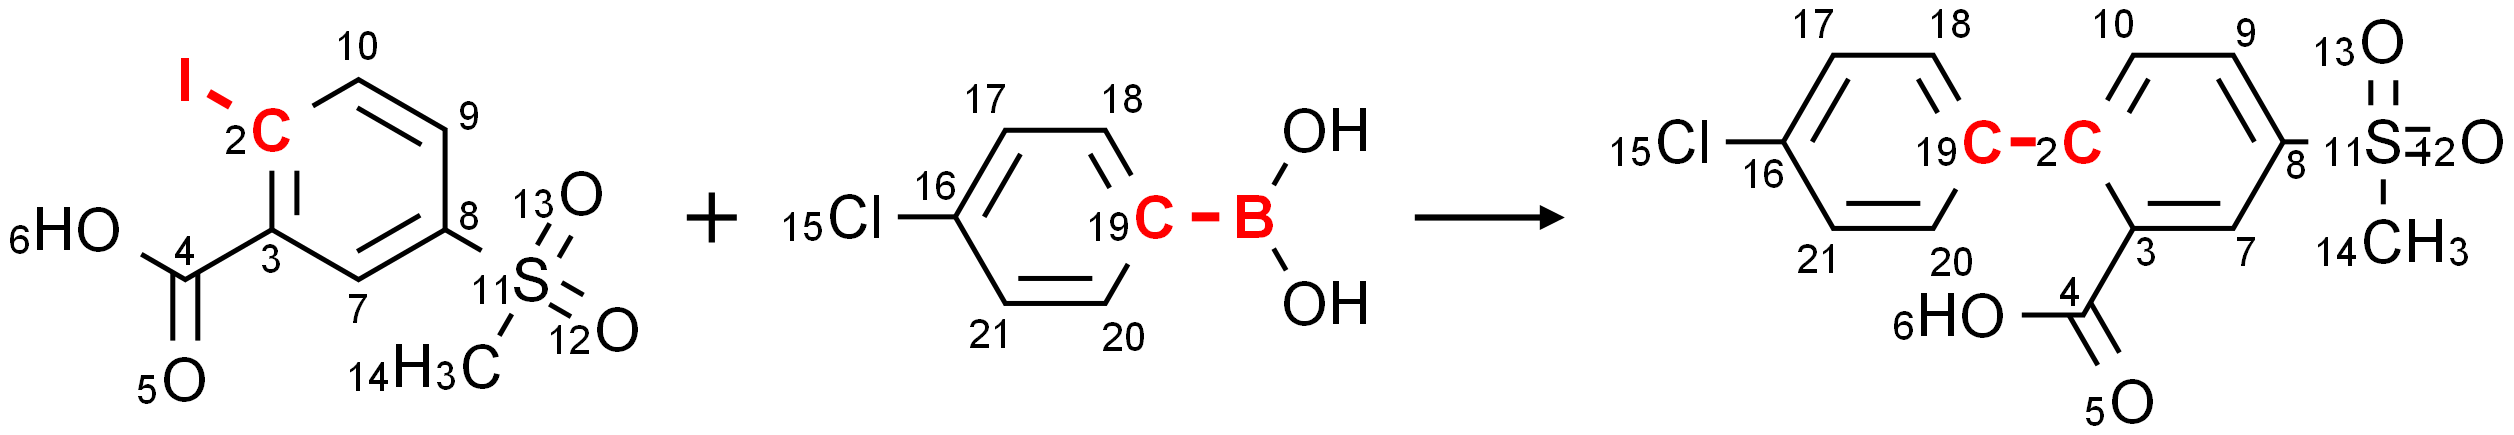

Prepared in analogy to Example B25 from 2-Iodo-5-methanesulfonyl-benzoic acid (example B19(b)) and 4-chloro-benzeneboronic acid. Light brown solid. MS (m/e): 309.1 ([M−H], 100%).


'ord-23dc764243ce439ea0248943deffc5f3'

In [99]:
from random import choice
from chem_render import indigo

SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,$([O]-S)]>>[C,c:1]-[C,c:2]"


# rxn = indigo.loadReaction(choice(suzuki_df.rxn_smiles))
# rxn.automap()

draw_reaction(suzuki_df, highlight_smi=SUZUKI_PATTERN)

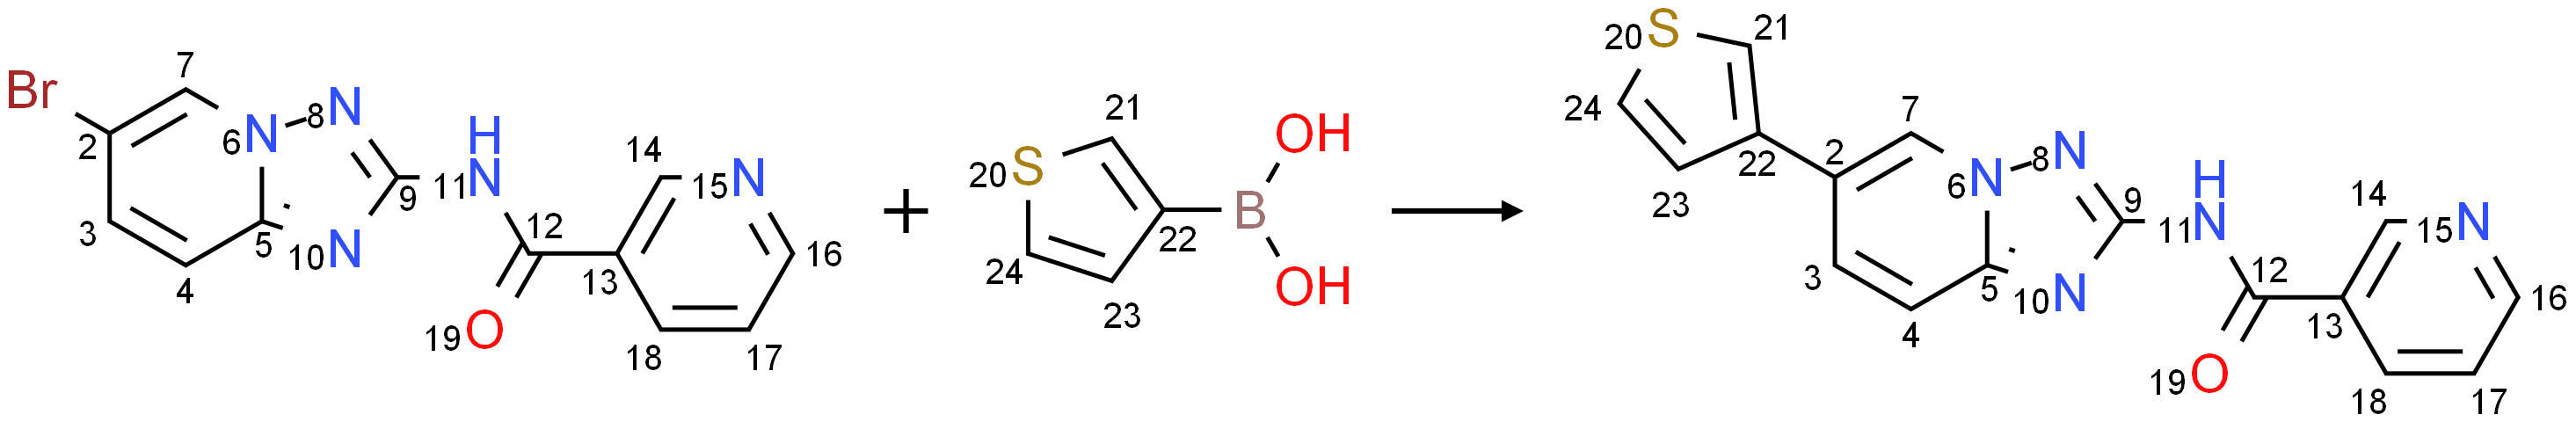

Patent:       US08263595B2
Reaction_id:  ord-c7e7131a5d5244dca00fccf319a880d9
The title compound was prepared following procedure described for intermediate A1 step a), but starting from N-(6-bromo[1,2,4]triazolo[1,5-a]pyridin-2-yl)nicotinamide ((B6), 75 mg; 0.24 mmol; 1.0 eq.) and 3-thienylboronic acid (60 mg; 0.47 mmol; 2.0 eq.). Purification by flash chromatography on silica (MeOH/EtOAc, 5:95) gave the title compound as a beige powder (18.1 mg, 23%). HPLC, Rt: 2.13 min. (purity 94.3%). LC/MS, M+(ESI): 322.3, M−(ESI): 320.2.


In [4]:
draw_reaction(suzuki_df[~suzuki_df['solvents'].apply(bool)])

In [5]:
full_text = "2 M aqueous Na2CO3 solution (0.84 mL) was added to a solution of (S)-6-(2-hydroxy-2-methylpropyl)-6-phenyl-3-[(S)-1-(4-(4,4,5,5-tetramethyl-1,3,2-dioxaborolan-2-yl)phenyl)ethyl]-1,3-oxazinan-2-one (0.40 g) and 5-bromo-1-cyclopropylmethyl-1H-pyridin-2-one (0.24 g) in dimethyl-formamide (4 mL). The resulting mixture was sparged with argon for 10 min, before [1,1′-bis(diphenylphosphino)ferrocene]-dichloropalladium(II) dichloromethane complex (34 mg) was added. The mixture was heated to 100° C. and stirred at this temperature for 4 h. After cooling to ambient temperature, water was added and the resulting mixture was extracted with ethyl acetate. The combined organic extracts were washed with brine, dried (MgSO4), and concentrated. The residue was purified by chromatography on silica gel (dichloromethane/methanol 99:1->95:5) to afford the title compound that was crystallized with little ethyl acetate. Yield: 0.19 g (46% of theory); Mass spectrum (ESI+): m/z=501 [M+H]+."

search_text = "9-Bromo-4,5-dihydro-6-oxa-3-thia-1-aza-benzo[e]azulene-2-carboxylic acid (2-hydroxy-ethyl)-isopropyl-amide"

In [6]:
matches = find_near_matches(search_text, full_text, max_l_dist=3)
if matches:
    for m in matches:
        print(m)


In [29]:
%%time
def match(sequence, subsequence):
    matches = find_near_matches(subsequence, sequence, max_l_dist=3)
    if matches:
        return True
    return False

mask = suzuki_df['notes'].apply(match, args=(full_text,))
mask.sum()

CPU times: total: 1.64 s
Wall time: 1.64 s


7

In [30]:
%%time
mask_exact = suzuki_df['notes'].str.contains(full_text, regex=False)
mask_exact.sum()

CPU times: total: 31.2 ms
Wall time: 35 ms


6

In [31]:
suzuki_df.loc[mask & ~mask_exact, 'notes'].iat[0]

'2 M aqueous Na2CO3 solution (0.84 mL) was added to a solution of (S)-6-(2-hydroxy-2-methylpropyl)-6-phenyl-3-[(S)-1-(4-(4,4,5,5-tetramethyl-1,3,2-dioxaborolan-2-yl)phenyl)ethyl]-1,3-oxazinan-2-one (0.40 g) and 5-bromo-1-cyclopropylmethyl-1H-pyridin -2-one (0.24 g) in dimethyl-formamide (4 mL). The resulting mixture was sparged with argon for 10 min, before [1,1′-bis(diphenylphosphino)ferrocene]-dichloropalladium(II) dichloromethane complex (34 mg) was added. The mixture was heated to 100° C. and stirred at this temperature for 4 h. After cooling to ambient temperature, water was added and the resulting mixture was extracted with ethyl acetate. The combined organic extracts were washed with brine, dried (MgSO4), and concentrated. The residue was purified by chromatography on silica gel (dichloromethane/methanol 99:1->95:5) to afford the title compound that was crystallized with little ethyl acetate. Yield: 0.19 g (46% of theory); Mass spectrum (ESI+): m/z=501 [M+H]+.'

In [32]:
suzuki_df.loc[mask_exact, 'notes'].iat[0]

'2 M aqueous Na2CO3 solution (0.84 mL) was added to a solution of (S)-6-(2-hydroxy-2-methylpropyl)-6-phenyl-3-[(S)-1-(4-(4,4,5,5-tetramethyl-1,3,2-dioxaborolan-2-yl)phenyl)ethyl]-1,3-oxazinan-2-one (0.40 g) and 5-bromo-1-cyclopropylmethyl-1H-pyridin-2-one (0.24 g) in dimethyl-formamide (4 mL). The resulting mixture was sparged with argon for 10 min, before [1,1′-bis(diphenylphosphino)ferrocene]-dichloropalladium(II) dichloromethane complex (34 mg) was added. The mixture was heated to 100° C. and stirred at this temperature for 4 h. After cooling to ambient temperature, water was added and the resulting mixture was extracted with ethyl acetate. The combined organic extracts were washed with brine, dried (MgSO4), and concentrated. The residue was purified by chromatography on silica gel (dichloromethane/methanol 99:1->95:5) to afford the title compound that was crystallized with little ethyl acetate. Yield: 0.19 g (46% of theory); Mass spectrum (ESI+): m/z=501 [M+H]+.'

In [51]:
from difflib import ndiff

seq_fuzz = suzuki_df.loc[mask & ~mask_exact, 'notes'].iat[0]
seq_exact = suzuki_df.loc[mask_exact, 'notes'].iat[0]

for s in ndiff(seq_exact, seq_fuzz):
    if s[0] == " ": continue
    print(f"{s[0]}: {s[1:]}")



+:   


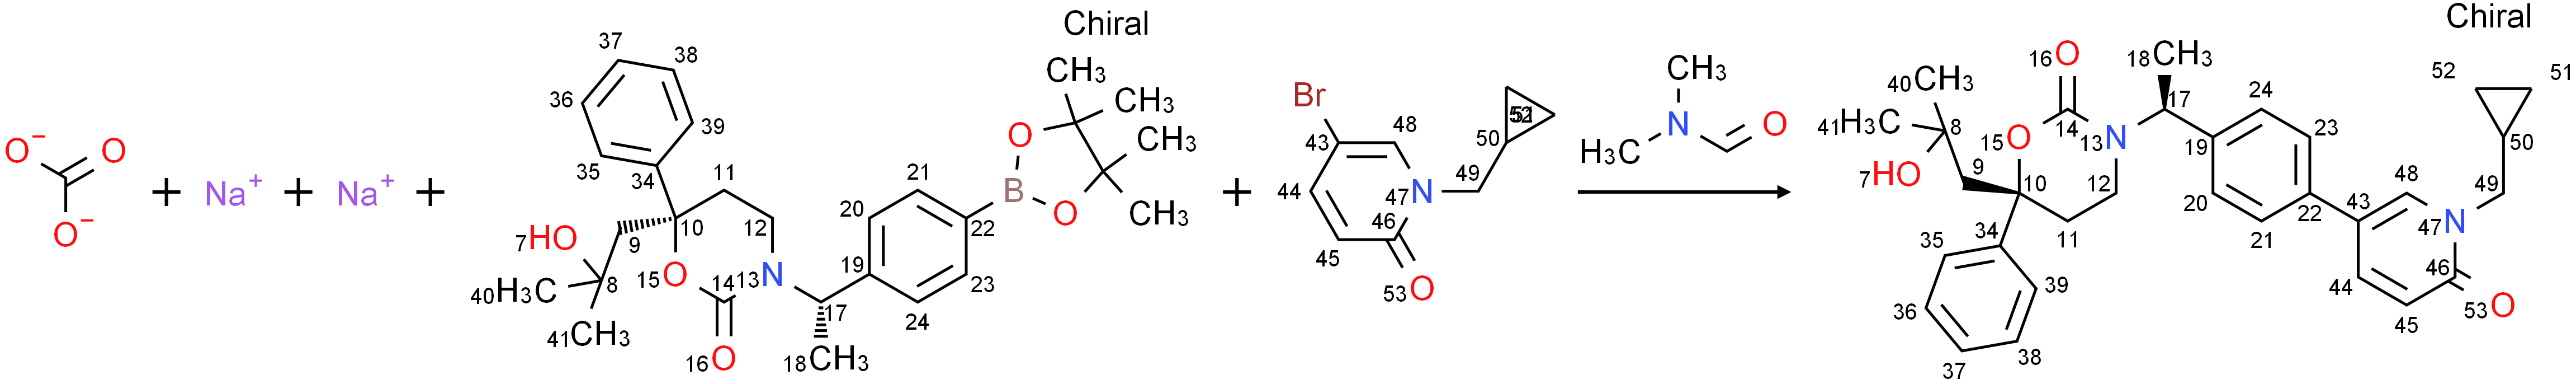

Patent:       US08575157B2
Reaction_id:  ord-40a652a4c67a4f2c953011c1523d8fc8
2 M aqueous Na2CO3 solution (0.84 mL) was added to a solution of (S)-6-(2-hydroxy-2-methylpropyl)-6-phenyl-3-[(S)-1-(4-(4,4,5,5-tetramethyl-1,3,2-dioxaborolan-2-yl)phenyl)ethyl]-1,3-oxazinan-2-one (0.40 g) and 5-bromo-1-cyclopropylmethyl-1H-pyridin-2-one (0.24 g) in dimethyl-formamide (4 mL). The resulting mixture was sparged with argon for 10 min, before [1,1′-bis(diphenylphosphino)ferrocene]-dichloropalladium(II) dichloromethane complex (34 mg) was added. The mixture was heated to 100° C. and stirred at this temperature for 4 h. After cooling to ambient temperature, water was added and the resulting mixture was extracted with ethyl acetate. The combined organic extracts were washed with brine, dried (MgSO4), and concentrated. The residue was purified by chromatography on silica gel (dichloromethane/methanol 99:1->95:5) to afford the title compound that was crystallized with little ethyl acetate. Yield: 0.19

In [8]:
draw_reaction(suzuki_df[mask])

In [9]:
suzuki_df.loc[mask, 'patent'].unique()

array(['US08754076B2', 'US08629138B2', 'US08138178B2', 'US08673899B2',
       'US08680093B2', 'US08114868B2', 'US08575157B2'], dtype=object)

In [10]:
suzuki_dd = dd.from_pandas(suzuki_df['notes'], npartitions=240)
mask_dd = suzuki_dd.apply(match,
               args=(search_text,),
               meta=pd.Series(dtype=bool)).compute(scheduler="threads")
mask_dd.sum()

[########################################] | 100% Completed | 1.63 sms


60

In [11]:
all_reactions = pd.read_pickle(f"{ORD_PATH}/all_reactions.pkl")
uspto_df = all_reactions.loc[~all_reactions['patent'].isna()]

In [12]:
uspto_dd = dd.from_pandas(uspto_df['notes'], npartitions=240)
mask_dd = uspto_dd.apply(match,
               args=(full_text,),
               meta=pd.Series(dtype=bool)).compute(scheduler="processes")
mask_dd.sum()
# mask = uspto_df['notes'].apply(match, args=(search_text,))

[########################################] | 100% Completed | 13.53 s


7

In [13]:
uspto_df.loc[mask_dd]

reaction_smile  \
id                                                                                        
ord-be66159866904e76938662ac07366c83  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   
ord-076bd0fdac2149e780d465a95cb6dc70  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   
ord-d8b9a8eb0ea44862ac9741115adeb8ae  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   
ord-aeb55b33497c4fabb9efc36219ea8c85  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   
ord-a1e436dfba464660a070b1c801f1313f  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   
ord-29a82ff48a474889b2ff08fa13afa2ee  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   
ord-40a652a4c67a4f2c953011c1523d8fc8  C([O-])([O-])=O.[Na+].[Na+].[OH:7][C:8]([CH3:4...   

                                                              solvents  \
id                                                                       
ord-be66159866904e76938662ac07366c83  [[dimethyl-formamide, CN(C=O)C]]   
ord-076bd0fdac2149e780d465a95cb6dc70  [[dimethyl-formamide, CN(C=O)C]]   
ord-d8b9a8eb0ea44862ac9741115adeb8ae  [[dimethyl-formamide, CN(C=O)C]]   
ord-aeb55b33497c4fabb9efc36219ea8c85  [[dimethyl-formamide, CN(C=O)C]]   
ord-a1e436dfba464660a070b1c801f1313f  [[dimethyl-formamide, CN(C=O)C]]   
ord-29a82ff48a474889b2ff08fa13afa2ee  [[dimethyl-formamide, CN(C=O)C]]   
ord-40a652a4c67a4f2c953011c1523d8fc8  [[dimethyl-formamide, CN(C=O)C]]   

                                                                              reactants  \
id                                                                                        
ord-be66159866904e76938662ac07366c83  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   
ord-076bd0fdac2149e780d465a95cb6dc70  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   
ord-d8b9a8eb0ea44862ac9741115adeb8ae  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   
ord-aeb55b33497c4fabb9efc36219ea8c85  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   
ord-a1e436dfba464660a070b1c801f1313f  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   
ord-29a82ff48a474889b2ff08fa13afa2ee  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   
ord-40a652a4c67a4f2c953011c1523d8fc8  [[Na2CO3, C(=O)([O-])[O-].[Na+].[Na+]], [(S)-6...   

                                     catalysts reagents temperature time  \
id                                                                         
ord-be66159866904e76938662ac07366c83        []       []       100.0  4.0   
ord-076bd0fdac2149e780d465a95cb6dc70        []       []       100.0  4.0   
ord-d8b9a8eb0ea44862ac9741115adeb8ae        []       []       100.0  4.0   
ord-aeb55b33497c4fabb9efc36219ea8c85        []       []       100.0  4.0   
ord-a1e436dfba464660a070b1c801f1313f        []       []       100.0  4.0   
ord-29a82ff48a474889b2ff08fa13afa2ee        []       []       100.0  4.0   
ord-40a652a4c67a4f2c953011c1523d8fc8        []       []       100.0  4.0   

                                                                                product  \
id                                                                                        
ord-be66159866904e76938662ac07366c83  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   
ord-076bd0fdac2149e780d465a95cb6dc70  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   
ord-d8b9a8eb0ea44862ac9741115adeb8ae  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   
ord-aeb55b33497c4fabb9efc36219ea8c85  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   
ord-a1e436dfba464660a070b1c801f1313f  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   
ord-29a82ff48a474889b2ff08fa13afa2ee  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   
ord-40a652a4c67a4f2c953011c1523d8fc8  C1(CC1)CN1C=C(C=CC1=O)C1=CC=C(C=C1)[C@H](C)N1C...   

                                     yield  \
id                                           
ord-be66159866904e76938662ac07366c83   NaN   
ord-076bd0fdac2149e780d465a95cb6dc70   NaN   
ord-d8b9a8eb0ea44862ac9741115adeb8ae   NaN   
ord-aeb55b33497c4fabb9efc36219e

In [14]:
uspto_dd = dd.from_pandas(suzuki_df['notes'], npartitions=240)
mask_dd = uspto_dd.apply(match,
                         args=(full_text,),
                         meta=pd.Series(dtype=bool)).compute(scheduler="threads")
mask_dd.sum()

[########################################] | 100% Completed | 1.97 sms


7